In [426]:
from polygon import RESTClient
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
import yfinance as yf
import time


#works best with constant markets. Does not perform well with bullish or bearish markets

class SimpleMovingAverage:
  def __init__(self, typ, period):
    self.period = period
    self.typ = typ
    self.data = []
    self.avg = -1 # needs updating - at least 1 day(s) of data required
  
  def update(self, new_delta):
    if self.typ == "gain" and new_delta < 0:
      new_delta = 0
    elif self.typ == "loss" and new_delta > 0:
      new_delta = 0
    self.data.append(abs(new_delta))
    if len(self.data) > self.period:
      self.data.pop(0)
    self.avg = sum(self.data) / len(self.data)
  
class RelativeStrengthIndex:
  def __init__(self, period=14):
    self.period = period
    self.last = -1
    self.rsi = -1 # needs updating - more than [period=14] day(s) of data required
    self.count = 0
    self.gain_avg = SimpleMovingAverage("gain", period)
    self.loss_avg = SimpleMovingAverage("loss", period)
  
  def update(self, new_data_point, time=""):
    if self.last >= 0:
      self.gain_avg.update(new_data_point - self.last)
      self.loss_avg.update(new_data_point - self.last)
    self.last = new_data_point
    self.count += 1
    if self.count > self.period:
      self.rsi = 100 - (100 / (1 + self.gain_avg.avg / (0.000000000000000000001 + self.loss_avg.avg)))

def generate_date_array(year):
    dates = []
    # Start from the first day of the given year
    current_date = datetime(year, 1, 1)
    # End on the last day of the given year
    end_date = datetime(year + 1, 1, 1)
    
    while current_date < end_date:
        # Format the date as "yyyy-mm-dd" and add it to the list
        date_string = current_date.strftime("%Y-%m-%d")
        dates.append(date_string)
        # Move to the next day
        current_date += timedelta(days=1)
    
    return dates

def graph_profits(data, type_of_profit):
    # Extract keys and values
    dates = list(data.keys())
    values = list(data.values())

    # Convert string dates to datetime objects
    dates = [datetime.strptime(date, '%Y-%m-%d') for date in dates]

    # Create a plot
    plt.figure(figsize=(8, 4))
    plt.plot(dates, values, marker='o', linestyle='-', color='b')

    # Format the x-axis to show dates properly
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator())

    # Label the axes
    plt.xlabel('Date')
    plt.ylabel(type_of_profit)
    plt.title(f'Model {type_of_profit} vs Holding Stock')

    # Rotate date labels for better readability
    plt.xticks(rotation=45)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()


def graph_transactions(transactions):
  # Convert transactions to a DataFrame for easier manipulation
  df = pd.DataFrame(transactions, columns=['Date', 'Price', 'Type'])

  # Convert the 'Date' column to datetime objects
  df['Date'] = pd.to_datetime(df['Date'])

  # Separate the transactions by type
  sell_transactions = df[df['Type'] == 'Sell']
  buy_transactions = df[df['Type'] == 'Buy']

  # Plotting
  plt.figure(figsize=(10, 6))

  # Plot sell transactions in red
  plt.scatter(sell_transactions['Date'], sell_transactions['Price'], color='red', label='Sell', marker='x')

  # Plot buy transactions in green
  plt.scatter(buy_transactions['Date'], buy_transactions['Price'], color='green', label='Buy', marker='o')

  # Labels and title
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.title('Transaction Prices Over Time')
  plt.legend()

  # Format the date on the x-axis
  plt.gcf().autofmt_xdate()

  # Show the plot
  plt.show()

In [427]:
def get_data(ticker, start_date, end_date):
    client = RESTClient("InxdvvQ5aFMwk5xWUpJUCpe8YHcimh8d")
    aggs = client.get_aggs(ticker, 1, "hour", start_date, end_date, limit=50000)
    print("Number of Data Points:",len(aggs))
    return aggs
    
    

In [428]:
def run_simulation(ticker, start_date, end_date, init_cash, init_shares, percent_invest, prices, times, buys, sells):
  transaction_times = sorted(buys + sells)
  transactions = []
  for t in transaction_times:
    price = prices[times.index(t)]
    if t in buys:
      transactions.append([t, price, "Buy"])
    else:
      transactions.append([t, price, "Sell"])
      
  print("Transactions: ", transactions)
  graph_transactions(transactions)
  # Execute Transactions through simulation
  cash = init_cash
  shares = init_shares
  print("Running Simulation for RSI with", ticker, "from", start_date, "to", end_date)
  print("Number of Transactions: ", len(transactions))
  print("Buys: ", len(buys), "Sells: ", len(sells))
  print("Open Price, Close Price: ", prices[0], prices[-1])
  print("Beginning Cash and Shares: ", cash, shares)
  portfolio_val_s = cash + prices[0] * shares
  print("Beginning Portfolio Value: ", portfolio_val_s)
  amt = cash * percent_invest / 100
  for order in transactions:
    if order[2] == "Buy":
      cash -= amt
      shares += amt/order[1]
    else:
      cash += amt
      shares -= amt/order[1]
  print("End Cash and Shares: ", cash, shares)
  portfolio_val_e = cash + prices[-1] * shares
  profit = portfolio_val_e - portfolio_val_s
  profit_percentage = (portfolio_val_e - portfolio_val_s) / portfolio_val_s * 100

  base_profit_percentage = init_shares*(prices[-1]-prices[0])/portfolio_val_s * 100

  print("End Portfolio Value: ", portfolio_val_e)
  print()
  print("Model Profit Percentage: ", profit_percentage)
  print("Market Change w/o trades", base_profit_percentage)
  print()
  print("Model outperforms market by", (profit_percentage - base_profit_percentage), "%") 


  return [cash, shares, profit, profit_percentage, base_profit_percentage]

In [429]:
def invest_rsi(ticker, data, start_date, end_date, cash=100000, shares=1000, percent_invest=20):
  aggs = data
  x_close = []
  y_close = []
  min_diff = 1
  for i in range(0, len(aggs), min_diff):
    agg = aggs[i]
    x_close.append(datetime.fromtimestamp(agg.timestamp // 1000).strftime("%Y-%m-%d %H:%M"))
    y_close.append(agg.close)

  
  #check if there is data for this time period
  if len(y_close) == 0:
    print("no data for this time period and stock")
    return(cash, shares, 0, 0, 0)

  # RSI execution
  data_x = []
  data_y = []
  low = []
  high = []
  rsi = RelativeStrengthIndex()
  last_rsi = -1
  buys = []
  sells = []
  
  # Parameters for trade strategy/execution
  low_threshold = 25
  high_threshold = 75
  
  for time, point in zip(x_close, y_close):
    rsi.update(point, time)
    if rsi.count > rsi.period:
      if last_rsi < 0:
        last_rsi = rsi.rsi
      data_x.append(time)
      data_y.append(rsi.rsi)
      low.append(low_threshold)
      high.append(high_threshold)
      if last_rsi < low_threshold and rsi.rsi >= low_threshold:
        buys.append(time)
      if last_rsi > high_threshold and rsi.rsi <= high_threshold:
        sells.append(time)
      last_rsi = rsi.rsi
      
  plt.figure(figsize=(10, 4))    
  plt.title(ticker + " RSI Indicator with Signals")
  plt.plot(data_x, data_y)
  plt.plot(data_x, low)
  plt.plot(data_x, high)
  for buy in buys:
    plt.axvline(x=buy, color="green")
  for sell in sells:
    plt.axvline(x=sell, color="red")
  ax = plt.gca()
  ax.set_xticks(ax.get_xticks()[::30])
  plt.show()

  plt.figure(figsize=(10, 4))
  plt.plot(x_close, y_close)
  plt.title(ticker + " Stock Price with Buy/Sell by RSI Indicator")
  for buy in buys:
    plt.axvline(x=buy, color="green")
  for sell in sells:
    plt.axvline(x=sell, color="red")
  ax = plt.gca()
  ax.set_xticks(ax.get_xticks()[::30])
  plt.show()

  return run_simulation(ticker, start_date, end_date, cash, shares, percent_invest, y_close, x_close, buys, sells)


In [430]:
def test_model(ticker, data, start_date, end_date, init_cash, init_shares, percent_invest):
    year1 = int(start_date[:4])
    year2 = int(end_date[:4])
    date_array = []
    for year in range(year1, year2+1):
        date_array += generate_date_array(year)

    
    cash, shares, profit, profit_percentage, base_profit_percentage = invest_rsi(ticker, data, start_date, end_date, init_cash, init_shares, percent_invest)
    alpha = profit_percentage - base_profit_percentage

    return alpha, profit_percentage

alphas_dict = {}



In [431]:
top_25_tickers = [
    "AAPL",  # Apple Inc.
    "MSFT",  # Microsoft Corporation
    "GOOGL", # Alphabet Inc. (Class A)
    "GOOG",  # Alphabet Inc. (Class C)
    "AMZN",  # Amazon.com Inc.
    "TSLA",  # Tesla Inc.
    "NVDA",  # NVIDIA Corporation
    "BRK.B", # Berkshire Hathaway Inc. (Class B)
    "META",  # Meta Platforms, Inc.
    "UNH",   # UnitedHealth Group Incorporated
    "JNJ",   # Johnson & Johnson
    "V",     # Visa Inc.
    "WMT",   # Walmart Inc.
    "XOM",   # Exxon Mobil Corporation
    "PG",    # Procter & Gamble Co.
    "JPM",   # JPMorgan Chase & Co.
    "MA",    # Mastercard Incorporated
    "LLY",   # Eli Lilly and Company
    "HD",    # The Home Depot, Inc.
    "CVX",   # Chevron Corporation
    "MRK",   # Merck & Co., Inc.
    "PEP",   # PepsiCo, Inc.
    "ABBV",  # AbbVie Inc.
    "KO",    # The Coca-Cola Company
    "SPY",    # S&P 500
    "TQQQ",   # 3x long QQQ
    "QQQ"    # QQQ NASDAQ 100
]

Invest RSI for TQQQ from 2024-06-09 to 2024-08-09
Number of Data Points: 669


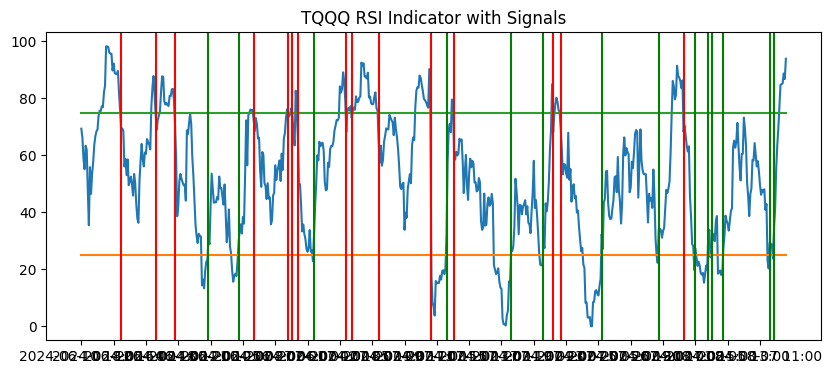

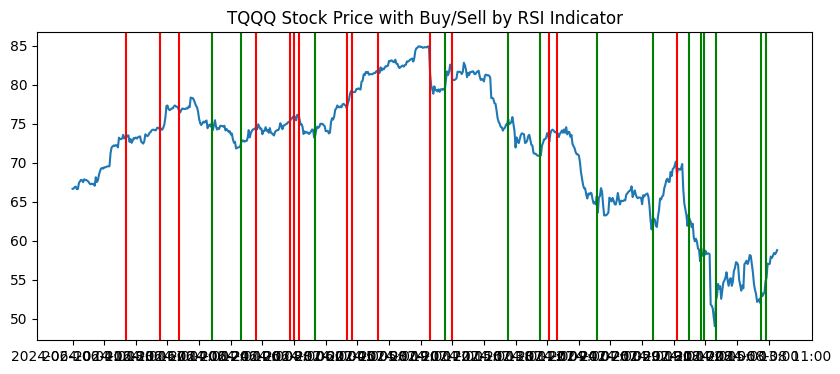

Transactions:  [['2024-06-13 07:00', 73.28, 'Sell'], ['2024-06-17 07:00', 74.54, 'Sell'], ['2024-06-18 09:00', 76.68, 'Sell'], ['2024-06-21 08:00', 75.09, 'Buy'], ['2024-06-25 04:00', 72.67, 'Buy'], ['2024-06-25 18:00', 74.41, 'Sell'], ['2024-06-27 18:00', 75.37, 'Sell'], ['2024-06-28 06:00', 75.9, 'Sell'], ['2024-06-28 11:00', 75.73, 'Sell'], ['2024-07-01 10:00', 73.4705, 'Buy'], ['2024-07-03 08:00', 76.99, 'Sell'], ['2024-07-03 13:00', 79.13, 'Sell'], ['2024-07-08 09:00', 81.8403, 'Sell'], ['2024-07-11 10:00', 81.43, 'Sell'], ['2024-07-12 08:00', 79.46, 'Buy'], ['2024-07-12 15:00', 80.63, 'Sell'], ['2024-07-18 04:00', 75.62, 'Buy'], ['2024-07-19 18:00', 70.95, 'Buy'], ['2024-07-22 11:00', 72.715, 'Sell'], ['2024-07-22 18:00', 74.049, 'Sell'], ['2024-07-25 08:00', 65.73, 'Buy'], ['2024-07-30 13:00', 62.725, 'Buy'], ['2024-08-01 04:00', 68.57, 'Sell'], ['2024-08-01 15:00', 63.33, 'Buy'], ['2024-08-02 11:00', 59.08, 'Buy'], ['2024-08-02 14:00', 58.14, 'Buy'], ['2024-08-05 09:00', 52.365

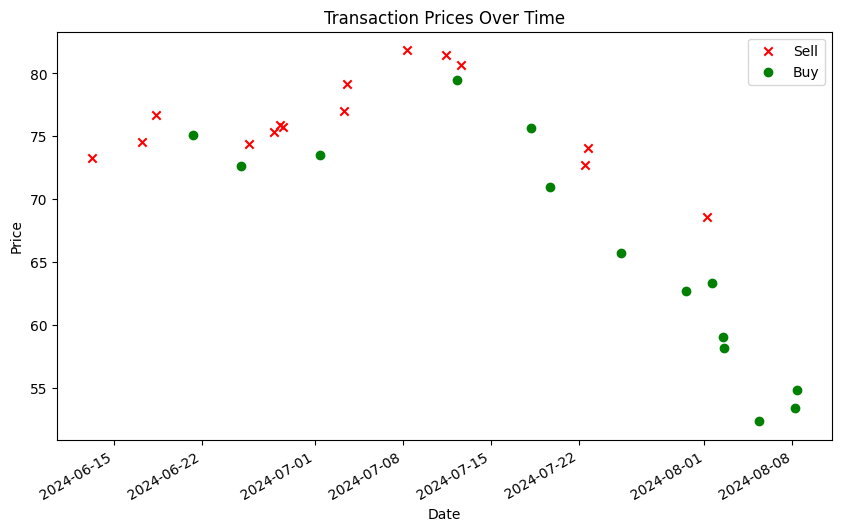

Running Simulation for RSI with TQQQ from 2024-06-09 to 2024-08-09
Number of Transactions:  29
Buys:  14 Sells:  15
Open Price, Close Price:  66.67 58.81
Beginning Cash and Shares:  500000.0 7499.625018749062
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  525000.0 8003.997510462645
End Portfolio Value:  995715.0935903082

Model Profit Percentage:  -0.42849064096917866
Market Change w/o trades -5.894705264736762

Model outperforms market by 5.466214623767584 %


Alphas for each stock: {'SPY': -1.5022375851971206, 'TQQQ': 5.466214623767584, 'QQQ': 8.271161533457416e-15, 'T': 0.4296593937470433}


In [444]:
#test
tickers = top_25_tickers[-2:-1]
start_date = "2024-06-09"
end_date =  "2024-08-09"
initial_portfolio_value = 1000000
count = 0

for ticker in tickers:
    if count % 5 == 0 and count != 0:
        print("Waiting for 60 seconds to avoid rate limit")
        time.sleep(45)
    count += 1
        

    print("Invest RSI for", ticker, "from" , start_date, "to" , end_date)
    
    data = get_data(ticker, start_date, end_date)
    # replace start price with start price of stock (you can find it in yahoo finance)
    start_price = data[0].close
   
    initial_cash = 0.5 * initial_portfolio_value
    initial_shares = (0.5 * initial_portfolio_value/start_price) if start_price > 0 else 1000
    percent_invest = 5
    alpha, profit = test_model(ticker, data, start_date, end_date, initial_cash, initial_shares, percent_invest) # can only run for about 1.5 yrs
    alphas_dict[ticker] = alpha
    print()
    print()
    

print("Alphas for each stock:", alphas_dict)

Average Alpha:  1.0984091080793787


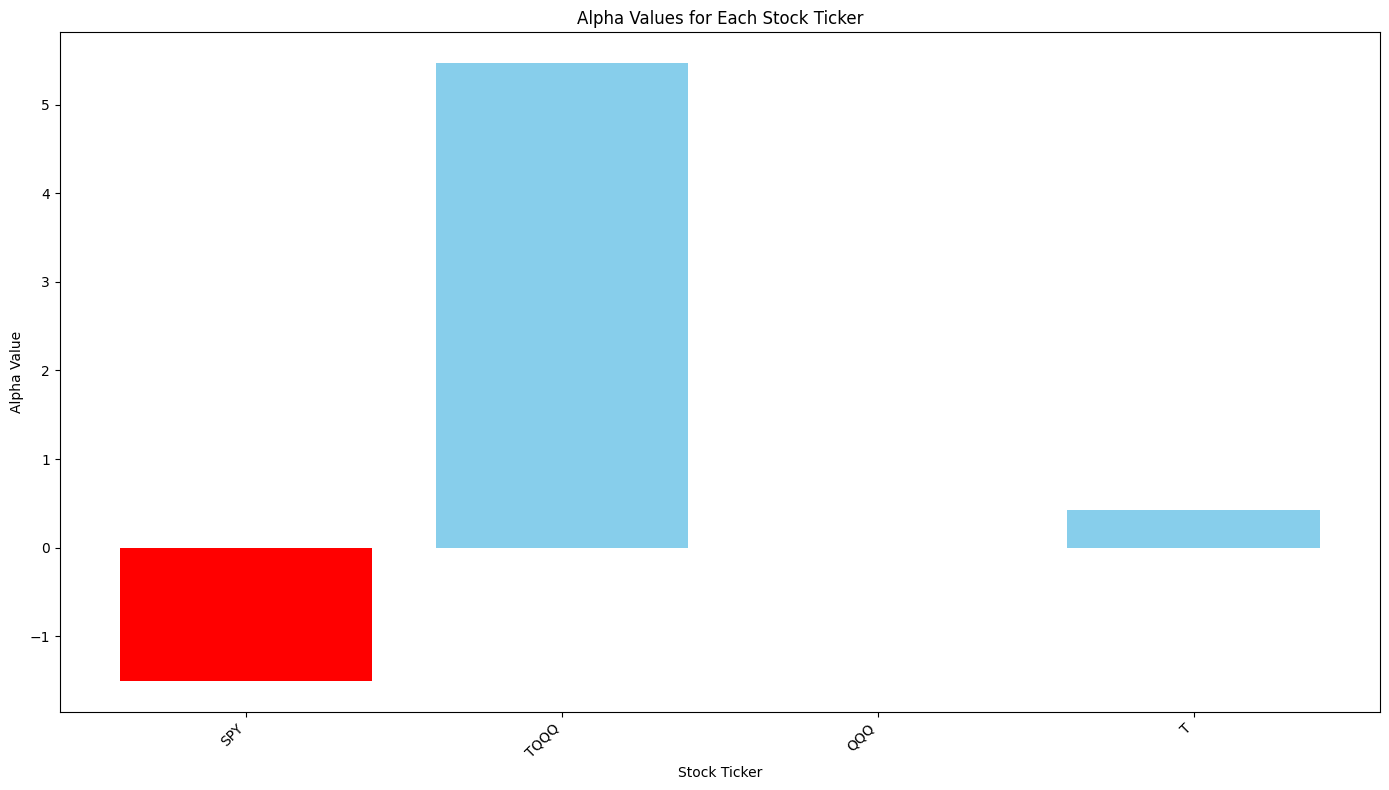

In [442]:
# Create lists of tickers and corresponding alphas
tickers = list(alphas_dict.keys())
alphas = list(alphas_dict.values())
print("Average Alpha: ", sum(alphas)/len(alphas))

colors = ['red' if alpha < 0 else 'skyblue' for alpha in alphas]  # Red for negative, blue for positive

# Plotting the data
plt.figure(figsize=(14, 8))
plt.bar(tickers, alphas, color=colors)

# Labels and title
plt.xlabel('Stock Ticker')
plt.ylabel('Alpha Value')
plt.title('Alpha Values for Each Stock Ticker')

# Rotate the x labels for better readability
plt.xticks(rotation=45, ha='right')


# Show the plot
plt.tight_layout()
plt.show()